In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

import itertools as it
from collections import Counter, defaultdict, deque

import sys
from analysis_utils import *

Error importing rpy2


In [25]:
VERSION = 'c0.5' #'c0.5'
data = get_data(VERSION, '../experiment/data')
#ids = pd.read_csv(f'../experiment/data/human_raw/{VERSION}/identifiers.csv').set_index('pid')

TRIALS = pd.read_json('../experiment/experiment/static/json/binary_tree_constant_high.json' ).set_index('trial_id').stateRewards

pdf = data['participants']
mdf = data['mouselab-mdp']
tdf = mdf.query('block == "test"').copy()

tdf.trial_index -= tdf.trial_index.min()
tdf.trial_index = tdf.trial_index.astype(int)
tdf.trial_id = tdf.trial_id.astype(int)

pdf['total_time'] = data['survey-text'].time_elapsed / 60000

def extract(q):
    return list(map(int, q['click']['state']['target']))

tdf['clicks'] = tdf.queries.apply(extract)
tdf['n_clicks'] = tdf.clicks.apply(len)
pdf['n_clicks'] = tdf.groupby('pid').n_clicks.mean()
pdf['score'] = tdf.groupby('pid').score.sum()

16.74  8.76  4.59


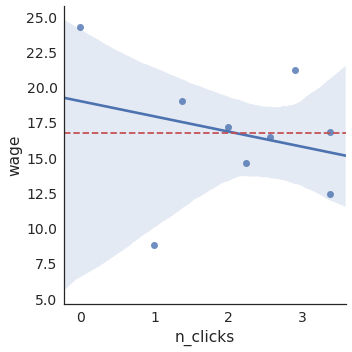

In [7]:
pdf['pay'] = (1 + pdf.bonus)
pdf['wage'] = pdf.pay / (pdf.total_time / 60)
print(f'{pdf.wage.mean():.2f}  {pdf.wage.min():.2f}  {pdf.wage.std():.2f}')

sns.lmplot('n_clicks', 'wage', data=pdf)
plt.axhline(pdf.wage.mean(), c='r', ls='--')

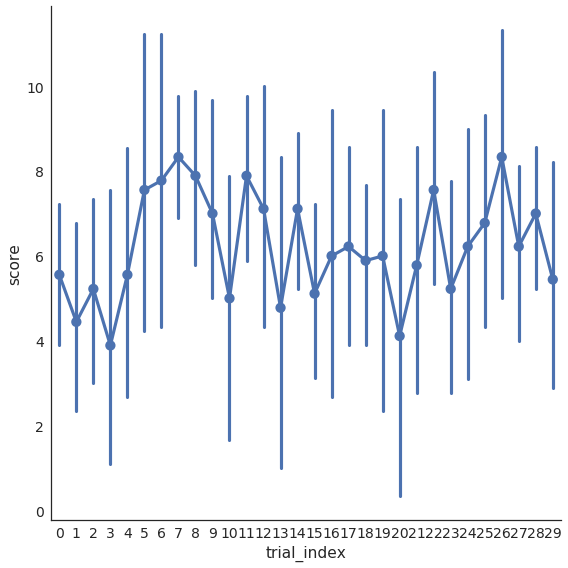

In [8]:
sns.factorplot('trial_index', 'score', data=tdf, size=8)

# Python stats

In [9]:
import statsmodels.formula.api as smf
model = smf.ols('score ~ trial_index', data=tdf).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  score   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                    0.2673
Date:                Wed, 24 Jan 2018   Prob (F-statistic):              0.606
Time:                        13:40:49   Log-Likelihood:                -779.59
No. Observations:                 270   AIC:                             1563.
Df Residuals:                     268   BIC:                             1570.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       6.0036      0.518     11.601      0.000       4.985       7.022
trial_index     0.0158      0.031      0.517      0.606      -0.044       0.076
==============================================================================
Omnibus:                        1.085   Durbin-Watson:                   2.088
Prob(Omnibus):                  0.581   Jarque-Bera (JB):                1.193
Skew:                          -0.126   Prob(JB):                        0.551
Kurtosis:                       2.794   Cond. No.                         33.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Test qualitative predictions

1. The first observed node is a stem node.
1. The second observed node is a leaf node.
1. Observe at least two pieces of information.
1. If the first observed node is a non-leaf and its revealed value is above average (5 or 10), then people should inspect a leaf node on the same branch. But if the value is below average (0 or -4) then they should inspect a leaf node on a different branch.
1. People should not stop after only two observations unless the non-leaf reward was below average and the leaf reward on the other branch was large (+10).
1. People should never stop collecting information until they have at least found a path with an above-average expected return (5 + mu_R) or have pruned all paths but one.
1. The aspiration level decreases as more information is observed. This means that the average expected return upon stopping should decrease with the number of observations.

### Prediction 1: The first observed node is a stem node rather than a leaf node.

In [209]:
from statsmodels.stats.proportion import binom_test

trial_ids = tdf['clicks'].keys()

first_click = np.array([])
second_click = np.array([])

first_observation = np.array([])

first_click_level = np.array([])
second_click_level = np.array([])

first_click_branch = np.array([])
second_click_branch = np.array([])

observed_value = np.array([])
second_observed_value = np.array([])

nr_levels = 2
nr_branches = 2

stem_nodes = [1,4]
leaf_nodes = [2,3,5,6]

nodes_by_depth=[stem_nodes,leaf_nodes]
nodes_by_branch=[[1,2,3],[4,5,6]]

nr_clicks = np.array([])

for t in trial_ids:
    clicks = tdf['clicks'][t]
    if len(clicks)>0:
        first_click = np.append(first_click,[clicks[0]])
        
        for level in range(nr_levels):
            if np.isin(first_click[-1],nodes_by_depth[level]):
                first_click_level = np.append(first_click_level,level+1)

        for branch in range(nr_branches):
            if np.isin(first_click[-1],nodes_by_branch[branch]):
                first_click_branch = np.append(first_click_branch,branch+1)
                
        #todo: push the observed value
        trial_id = tdf['trial_id'][t]
        
        first_obs = TRIALS[trial_id][int(first_click[-1])]
        observed_value = np.append(observed_value,[first_obs])
        nr_clicks = np.append(nr_clicks,len(clicks))
        if len(clicks)>1:
            second_click = np.append(second_click,[clicks[1]])
            for level in range(nr_levels):
                if np.isin(second_click[-1],nodes_by_depth[level]):
                    second_click_level = np.append(second_click_level,level+1)
            
            for branch in range(nr_branches):
                if np.isin(second_click[-1],nodes_by_branch[branch]):
                    second_click_branch = np.append(second_click_branch,branch+1)
            
            second_obs = TRIALS[trial_id][int(second_click[-1])]
            second_observed_value= np.append(second_observed_value,[second_obs])

        else:
            second_click = np.append(second_click,[17])
            second_click_level = np.append(second_click_level,[0])
            second_click_branch = np.append(second_click_branch,[0])
            second_observed_value = np.append(second_observed_value,[None])


print("{:4.1f}% of the first clicks were on stem nodes.".format(100*np.mean(first_click_level==1)))
print("{:4.1f}% of the first clicks were on leaf nodes.".format(100*np.mean(first_click_level==2)))

#int(np.sum(first_click_level==1))
p_more_than_half = binom_test(int(np.sum(first_click_level==1)),int(len(first_click_level)),0.5,'larger')
print("Like the optimal strategy, people's first click is more often a stem than a leaf node (p={}).".format(p))

p_less_than_one = binom_test(int(np.sum(first_click_level==1)),int(len(first_click_level)),1,'smaller')



95.8% of the first clicks were on stem nodes.
 4.2% of the first clicks were on leaf nodes.
Like the optimal strategy, people's first click is more often a stem than a leaf node (p=1.1529351115423921e-54).


### Prediction 2: The second click is on a leaf node

In [214]:
print("{:4.1f}% of the second clicks were on leaf nodes.".format(100*np.mean(second_click_level==2)))

p_second_click = binom_test(int(np.sum(first_click_level==2)),int(len(second_click_level)),0.5)

print("This is significantly less often than would be expected by chance (p={}).".format(p_second_click))

29.2% of the second clicks were on leaf nodes.
This is significantly less often than would be expected by chance (p=2.3058702230847842e-54).


### Prediction 3: Participants make at least two clicks on every trial.

In [215]:
print("Participants collect at least two pieces of information on {:4.1f}% of the trials.".format(100*np.mean(nr_clicks>=2)))

p_nr_clicks = binom_test(int(np.sum(nr_clicks>=2)),int(len(nr_clicks)),0.5)

print("This is significantly more often than would be expected by chance (p={}).".format(p_nr_clicks))

Participants collect at least two pieces of information on 76.3% of the trials.
This is significantly more often than would be expected by chance (p=2.2980410086122564e-16).


### Prediction 4: If the first observed node is a non-leaf and its revealed value is above average (5 or 10), then people should inspect a leaf node on the same branch. But if the value is below average (0 or -4) then they should inspect a leaf node on a different branch.

In [223]:
same_branch = first_click_branch[nr_clicks>1] == second_click_branch[nr_clicks>1]
branch_switch = first_click_branch[nr_clicks>1] != second_click_branch[nr_clicks>1]

smallest_good_value = 5
best_bad_value = 0
leaf_level = 2

good_observation = observed_value[nr_clicks>1] >= smallest_good_value
bad_observation = observed_value[nr_clicks>1] <= best_bad_value

stopped_after_good_obs = second_click_level[np.logical_and(observed_value>= smallest_good_value , first_click_level < leaf_level)]==0
stopped_after_good_observation = 100 * np.mean(stopped_after_good_obs)
p_stopped = binom_test(int(np.sum(stopped_after_good_obs)),int(len(stopped_after_good_obs)),0.5)

continued_after_bad_obs = second_click_level[np.logical_and(observed_value<= best_bad_value , first_click_level < leaf_level)]!=0
continued_after_bad_observation = 100 * np.mean(continued_after_bad_obs)
p_continued = binom_test(int(np.sum(continued_after_bad_obs)),int(len(continued_after_bad_obs)),0.5)




print("If the observed value was bad then {:3.1f}% continued planning (p={}).".format(continued_after_bad_observation,p_continued))
print("If the observed value was good then {:3.1f}% stopped planning (p={}).".format(stopped_after_good_observation,p_stopped))

switch_away_from_bad = branch_switch[bad_observation]
p_switched_from_bad = binom_test(int(np.sum(switch_away_from_bad)),int(len(switch_away_from_bad)),0.5)

switch_away_from_good = branch_switch[good_observation]
p_switched_from_good = binom_test(int(np.sum(switch_away_from_good)),int(len(switch_away_from_good)),0.5)

print("If the observed value was bad then {:3.1f}% switched the branch (p={}).".format(100*np.mean(switch_away_from_bad),p_switched_from_bad))
print("If the observed value was good then {:3.1f}% switched the branch (p={}).".format(100*np.mean(switch_away_from_good),p_switched_from_good))


percent_leafs_after_good_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value>= smallest_good_value , first_click_level < leaf_level)]==leaf_level)
percent_leafs_after_bad_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value<= best_bad_value , first_click_level < leaf_level)]==leaf_level)



leaf_on_same_branch = np.logical_and(second_click_level[nr_clicks>1]==leaf_level,same_branch)
nonleaf_on_different_branch = np.logical_and(branch_switch, second_click_level[nr_clicks>1]<leaf_level)
leaf_on_different_branch = np.logical_and(branch_switch, second_click_level[nr_clicks>1]==leaf_level)

print("\nFrequency of agreement with the model: ")
print("{:3.1f}% of the clicks following a good observation were leafs on the same branch.".format(100*np.mean(leaf_on_same_branch[good_observation])))
print("{:3.1f}% of the clicks following a bad observation were leafs on the other branch.".format(100*np.mean(leaf_on_different_branch[bad_observation])))
print("{:3.1f}% of the clicks following a bad observation were the stem of the other branch.".format(100*np.mean(nonleaf_on_different_branch[bad_observation])))

print("\nFrequency of disagreement with the model: ")
print("Following a bad observation participants inspected the stem of the other branch {:3.1f}% of the time.".format(100*np.mean(nonleaf_on_different_branch[bad_observation])))
print("Following a bad observation participants inspected a leaf on the same branch {:3.1f}% of the time.".format(100*np.mean(leaf_on_same_branch[bad_observation])))
#print(np.mean(leafs_on_same_branch[bad_observation]))
#print(np.mean(nonleaf_on_different_branch[good_observation]))


#percent_leafs_after_bad_obs = 100 * np.mean(second_click_level[np.logical_and(observed_value<= best_bad_value , first_click_level < leaf_level)]==leaf_level)


print("\nIf the observed value was above average, then {:3.1f}% clicked on a leaf afterward.".format(percent_leafs_after_good_obs))
print("If the observed value was below average, then {:3.1f}% clicked on a leaf afterward".format(percent_leafs_after_bad_obs))

If the observed value was bad then 83.3% continued planning (p=7.288430776686279e-07).
If the observed value was good then 25.5% stopped planning (p=0.0006210434562277105).
If the observed value was bad then 89.1% switched the branch (p=4.405936238072169e-08).
If the observed value was good then 23.7% switched the branch (p=0.0016580525261815653).

Frequency of agreement with the model: 
76.3% of the clicks following a good observation were leafs on the same branch.
10.9% of the clicks following a bad observation were leafs on the other branch.
78.3% of the clicks following a bad observation were the stem of the other branch.

Frequency of disagreement with the model: 
Following a bad observation participants inspected the stem of the other branch 78.3% of the time.
Following a bad observation participants inspected a leaf on the same branch 10.9% of the time.

If the observed value was above average, then 56.9% clicked on a leaf afterward.
If the observed value was below average, then

### Prediction 5: People should not stop after only two observations unless the non-leaf reward was below average and the leaf reward on the other branch was large (+10).

In [78]:
at_least_two_clicks = nr_clicks>=2

stopped_after_two_clicks = nr_clicks[at_least_two_clicks]==2

condition_on_values = np.logical_and(second_observed_value[at_least_two_clicks] >= 10, observed_value[at_least_two_clicks] <= best_bad_value)
condition_on_levels = np.logical_and(first_click_level[at_least_two_clicks] < leaf_level, second_click_level[at_least_two_clicks] == leaf_level)

condition_for_stopping = np.logical_and(condition_on_values,condition_on_levels)

print("If it was bounded optimal to stop after the second click, then {:3.1f}% of the participants stopped.".format(100*np.mean(stopped_after_two_clicks[condition_for_stopping])))
print("If it was suboptimal to stop after the second click, then {:3.1f}% of the participants stopped.".format(100*np.mean(stopped_after_two_clicks[~condition_for_stopping])))

If it was bounded optimal to stop after the second click, then nan% of the participants stopped.
If it was suboptimal to stop after the second click, then 47.2% of the participants stopped.


/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2909: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/falklieder/miniconda3/envs/mcrl/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


### Prediction 6: People should never stop collecting information until they have at least found a path with an above-average expected return (5 + mu_R) or have pruned all paths but one.

In [159]:
def make_env(env_type, cost=1., seed=None, **kwargs):
    if seed is not None:
        np.random.seed(seed)

    sigmas = get(env_type, {
        "binary_tree_constant_high": [0,6,6],
        "binary_tree_increasing": [0, 2, 20],
        "binary_tree_decreasing": [0,20,2],
        "binary_tree_constant_low": [0,1,1],
    })
    
    def reward(depth):
        if depth > 0:
            return Normal(3, sigmas[depth]).to_discrete(6)
        return 0.
    
    branching = [2,2]
    return MouselabEnv.new_symmetric(branching, reward, cost=cost, **kwargs)

In [228]:
#Compute the expected termination rewards
COST=1
trial_ids = tdf['clicks'].keys()

term_rewards = np.array([])
nr_clicks = np.array([])

mu_R = 3
mu_path = 2*mu_R

all_alternatives_pruned = np.array([])
    
for t in trial_ids:

    trial_id = tdf['trial_id'][t]
    ground_truth = TRIALS[trial_id]
    env = make_env('binary_tree_constant_high', cost=COST, ground_truth=ground_truth)
    clicks = tdf['clicks'][t]

    #ER_by_path = [env.node_quality(path[-1]).expectation() for path in env.all_paths()]
    #print(ER_by_path)
    
    for click in clicks:
        step=env.step(click)
    
    nr_clicks = np.append(nr_clicks,[len(clicks)])

    if len(clicks)>0:    
        term_rewards = np.append(term_rewards,env.expected_term_reward(step[0]))
    else:
        term_rewards = np.append(term_rewards,env.expected_term_reward(env._state))
        
    
    ER_by_path = [env.node_quality(path[-1]).expectation() for path in env.all_paths()]
    
    #ER_by_path = np.zeros(len(paths))
    #for p in range(len(paths)):
    #    ER_by_path[p] = 0
    #    for n in paths[p]:
    #        ER_by_path[p]+= ER_of_node(env._state[n])

    #print(ER_by_path)
    all_alternatives_pruned = np.append(all_alternatives_pruned, np.sum(np.less(ER_by_path,0))>=3)
    

#print(np.mean(all_alternatives_pruned))    

freq_stop_early = 100*np.mean(term_rewards[np.logical_and( nr_clicks<6, all_alternatives_pruned==0)]<= mu_path)
print("Participants stopped planning too early on {:3.1f}% of the trials.".format(freq_stop_early))


Participants stopped planning too early on 35.2% of the trials.


### Prediction 7: The aspiration level decreases as more information is observed. This means that the average expected return upon stopping should decrease with the number of observations.

In [238]:
from statsmodels.formula.api import ols

avg_expected_return = np.zeros(7)

for i in range(7):
    avg_expected_return[i] = np.mean(term_rewards[nr_clicks==i])
    print("When participants stopped planning after {} clicks, then the average expected termination reward was {:3.1f}.".format(i,avg_expected_return[i]))

data = {'term_rewards': term_rewards, 'nr_clicks': nr_clicks}    
lm = ols('term_rewards ~ nr_clicks', data=data).fit()
lm.summary()

When participants stopped planning after 0 clicks, then the average expected termination reward was 6.0.
When participants stopped planning after 1 clicks, then the average expected termination reward was 7.7.
When participants stopped planning after 2 clicks, then the average expected termination reward was 8.6.
When participants stopped planning after 3 clicks, then the average expected termination reward was 9.7.
When participants stopped planning after 4 clicks, then the average expected termination reward was 8.5.
When participants stopped planning after 5 clicks, then the average expected termination reward was 8.2.
When participants stopped planning after 6 clicks, then the average expected termination reward was 6.4.


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           term_rewards   R-squared:                       0.041
Model:                            OLS   Adj. R-squared:                  0.038
Method:                 Least Squares   F-statistic:                     11.55
Date:                Thu, 25 Jan 2018   Prob (F-statistic):           0.000781
Time:                        10:46:56   Log-Likelihood:                -665.98
No. Observations:                 270   AIC:                             1336.
Df Residuals:                     268   BIC:                             1343.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      7.3838      0.317     23.271      0.000       6.759       8.009
nr_clicks      0.4315      0.127      3.398      0.001       0.182       0.682
==============================================================================
Omnibus:                       13.765   Durbin-Watson:                   1.764
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               14.486
Skew:                           0.558   Prob(JB):                     0.000715
Kurtosis:                       3.209   Cond. No.                         5.09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [234]:
avg_expected_return[0]

IndexError: too many indices for array

# R stats

In [15]:
import rpy2.robjects as ro
from rpy2.robjects import pandas2ri
pandas2ri.activate()
from rpy2.robjects.conversion import ri2py
%load_ext rpy2.ipython

ModuleNotFoundError: No module named 'rpy2'

In [8]:
rdf = df2r(tdf, ['trial_index', 'score'])

In [22]:
%%R -i rdf
m = lm(score ~ trial_index, data=rdf)
summary(m)


Call:
lm(formula = score ~ trial_index, data = rdf)

Residuals:
     Min       1Q   Median       3Q      Max 
-117.073  -17.312    2.346   21.598   75.047 

Coefficients:
            Estimate Std. Error t value Pr(>|t|)    
(Intercept)  25.7907     2.5408  10.151   <2e-16 ***
trial_index  -0.1197     0.2286  -0.523    0.601    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 30.06 on 518 degrees of freedom
Multiple R-squared:  0.0005286,	Adjusted R-squared:  -0.001401 
F-statistic: 0.2739 on 1 and 518 DF,  p-value: 0.6009



In [29]:
joblib.dump(list(zip(tdf.trial_id, tdf.clicks)), 'data/empirical_clicks.pkl')

[autoreload of train_policies failed: Traceback (most recent call last):
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 246, in check
    superreload(m, reload, self.old_objects)
  File "/usr/local/lib/miniconda3/lib/python3.6/site-packages/IPython/extensions/autoreload.py", line 369, in superreload
    module = reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/imp.py", line 315, in reload
    return importlib.reload(module)
  File "/usr/local/lib/miniconda3/lib/python3.6/importlib/__init__.py", line 166, in reload
    _bootstrap._exec(spec, module)
  File "<frozen importlib._bootstrap>", line 618, in _exec
  File "<frozen importlib._bootstrap_external>", line 674, in exec_module
  File "<frozen importlib._bootstrap_external>", line 781, in get_code
  File "<frozen importlib._bootstrap_external>", line 741, in source_to_code
  File "<frozen importlib._bootstrap>", line 219, in _call_with_frames_removed
  File "bin/trai

['data/empirical_clicks.pkl']

In [41]:
def empirical_state_actions():
    for trial_id, clicks in zip(tdf.trial_id, tdf.clicks):
        if trial_id == 24987:
            continue # collision!
        env = make_env('constant_high', ground_truth=trials[trial_id])
        pol = FixedPlanPolicy([*clicks, env.term_action])
        trace = run_episode(pol, env)
        yield from zip(trace['states'], trace['actions'])

In [10]:
pol = lc_policy([-40, 1, 0, 0])

def yoked_returns(trial_id, clicks):
    env = make_env('constant_high', ground_truth=trials[trial_id])
    for click in clicks:
        yield sum(run_episode(pol, env)['rewards'])
        env.reset()
        env.init = env.step(click)[0]
 

In [12]:
from toolz import partition_all, concat
args = 
chunk_size = 10
chunks = partition_all(chunk_size, args)
def one(chunk):
    return sum(concat(yoked_returns(*args) for args in chunk))

one(next(chunks))